# Домашнее задание "Сингулярный спектральный анализ"
## Задание
### Провести анализ с помощью SSA на любом из временных рядов с первого занятия. При желании, можно воспользоваться своим временным рядом (работа, kaggle и тд). Посмотрите на результаты с разными длинами окон. Обязательно визуализируйте результаты, аналогично материалу с занятия.


### Импорт библиотек

In [1]:
# Load the usual suspects:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

### Импорт данных


In [2]:
# нестационарный ряд
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")

In [42]:
sales_of_company_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   77 non-null     object
 1   Count   77 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ KB


In [3]:
sales_of_company_x.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


In [4]:
df = sales_of_company_x['Count']

### Вспомогательный класс для SSA


SSA - удобный класс, образно названный *`SSA`*. Каждый экземпляр класса будет содержать декомпозицию временного ряда для некоторой длины окна $L$ и предоставлять полезные методы для анализа, построения и реконструкции временного ряда.

Алгоритм SSA:
1. Для временного ряда $F = (f_0, \ f_1, \ldots, \ f_{N-1})$ и длины окна $L$ сформируйте матрицу траекторий $\mathbf{X}$ со столбцами, заданными векторами $(f_i, \ldots, f_{L+i-1})^{\text{T}}$, $0 \le i \le N-L$.
2. Разложите $\mathbf{X}$ с сингулярным разложением, $\mathbf{X} = \sum_{i=0}^{d-1}\sigma_i U_i V^{\text{T}}_i$.
3. Постройте элементарные матрицы $d$ $\mathbf{X}_i = \sigma_i U_i V^{\text{T}}_i$.
4. По диагонали усредните $\mathbf{X}_i$, чтобы сформировать элементарные компоненты временного ряда $\tilde{F}_i$, такие что $F = \sum_{i=0}^{d-1} \tilde{F}_i$.
5. Вычислите и сохраните взвешенную корреляционную матрицу $\mathbf{W}_{\text{corr}}$ для $\tilde{F}_i$.

In [5]:
class SSA(object):
    'Класс для Сингулярного спектрального анализа '
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

### Решение

#### Отображение данных  

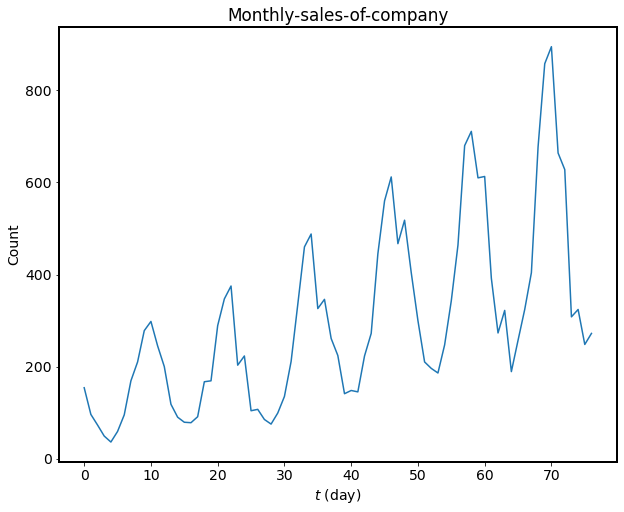

In [21]:
df.plot()
plt.xlabel(r"$t$ (day)")
plt.ylabel("Count")
plt.title("Monthly-sales-of-company");

Видно, что объёмы продаж имеют тенденцию роста с сезонностью и цикличностью от года к году, что говорит об успешности реализации товара бизнеса.

####  Длина окна
Механизм, позволяющий легко исследовать влияние параметра длины окна, $L$, на декомпозицию нашего временного ряда.

###  $L = 2$
Длина окна 2 может показаться бесполезным выбором, но это хорошее место, чтобы начать и наблюдать, как временные ряды разлагаются на все больше и больше компонентов. Мы будем использовать удобный метод `SSA.components_to_df ()`, чтобы вернуть фрейм данных Pandas и построить все элементарные компоненты сразу.

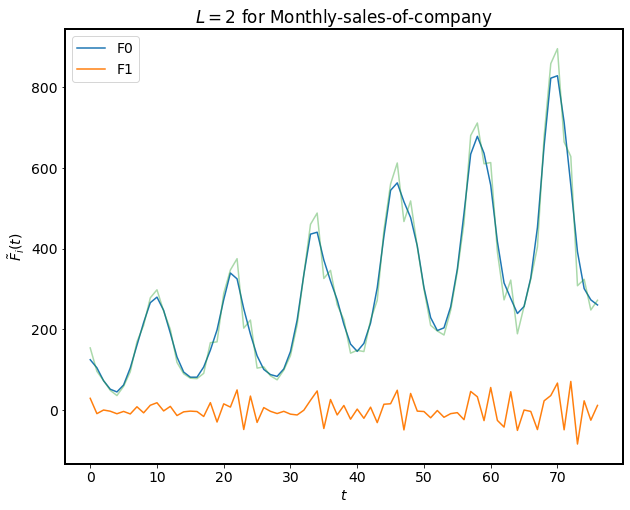

In [23]:
F_ssa_L2 = SSA(df, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for Monthly-sales-of-company");

Для $L=2$ мы можем ожидать возврата только двух элементарных компонентов. Даже при такой небольшой длине окна алгоритм SSA начал отделять высокочастотный шум от ряда, давая нам несколько ослабленную версию исходного ряда в компоненте $\tilde{F}_0$.

## $L = 5$<a name="Section5.2"></a>
Давайте подойдем к окну длиной 5 и посмотрим, что происходит с элементарными компонентами:

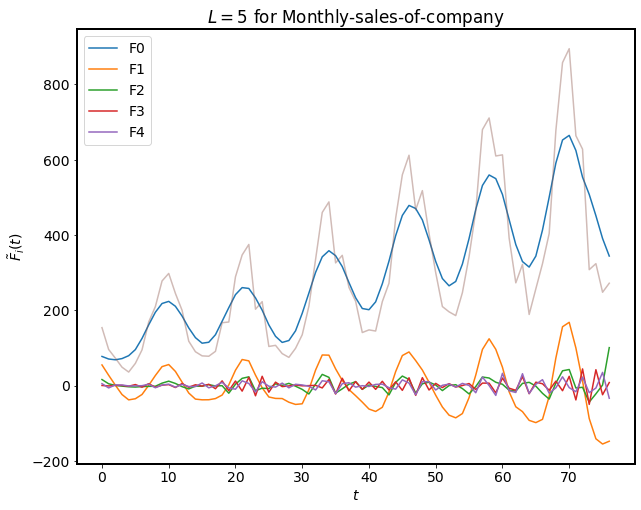

In [24]:
F_ssa_L5 = SSA(df, 5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for Monthly-sales-of-company");
plt.show()

Мы видим, что $\tilde{F}_0$ сейчас хорошо и по-настоящему обработанных версии оригинального сериала. $\tilde{F}_1$ является аналогом $\tilde{F}_0$ без трендовой составляющей при этом периодическая, в то время как $\tilde{F}_2$ - $\tilde{F}_4$ являются просто шумом.

## $L = 20$<a name="Section5.3"></a>

Давайте увеличим длину окна в четыре раза, и вместо того, чтобы проверять элементарные компоненты, мы рассмотрим полученную w-корреляционную матрицу и сначала примем некоторые решения о группировке.

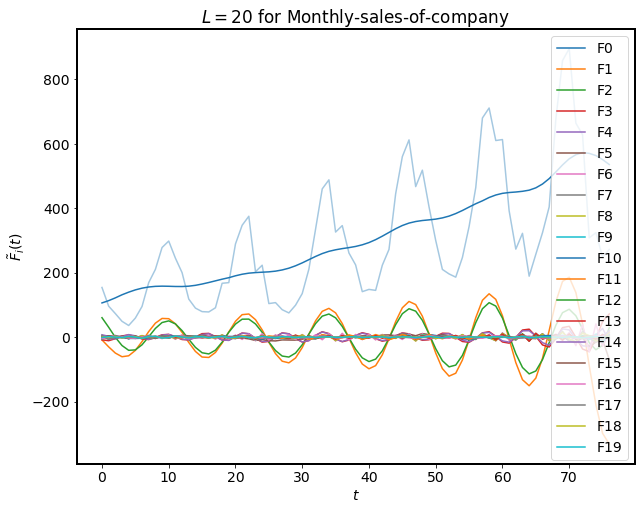

In [26]:
F_ssa_L20 = SSA(df, 20)
F_ssa_L20.components_to_df().plot()
F_ssa_L20.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=20$ for Monthly-sales-of-company");
plt.show()

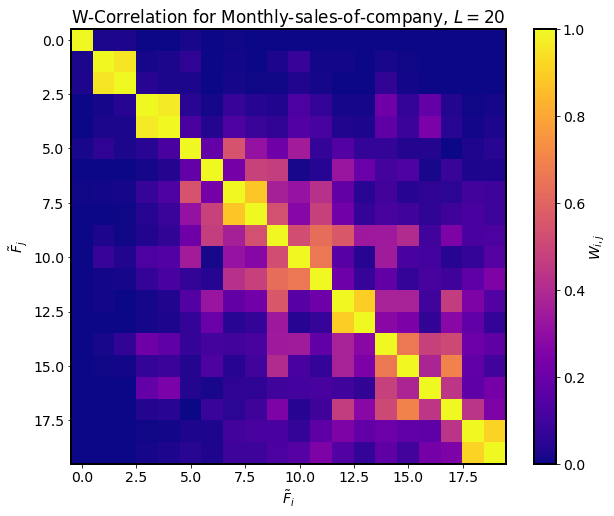

In [27]:
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for Monthly-sales-of-company, $L=20$");

w-корреляционная матрица для $L=20$ разбита (грубо) на два блока: $\tilde{F}_0$ to $\tilde{F}_3$ и $\tilde{F}_4$ to $\tilde{F}_{19}$. Внутри этих блоков размер значений $W_{i,j}$ предполагает, что нам нужно сгруппировать $\tilde{F}_1$, $\tilde{F}_2$ и $\tilde{F}_3$, а также сгруппировать все $ \tilde{F}_4, \ldots,\tilde{F}_{19}$. Эта группировка, конечно, не идеальна, так как $\tilde{F}_3$ имеет не пренебрежимо малую w-корреляцию с компонентами во втором блоке. Мы построим выбранные нами группировки компонентов вместе с $\tilde{F}_3$ сами по себе и посмотрим, оправдан ли наш выбор группировки:

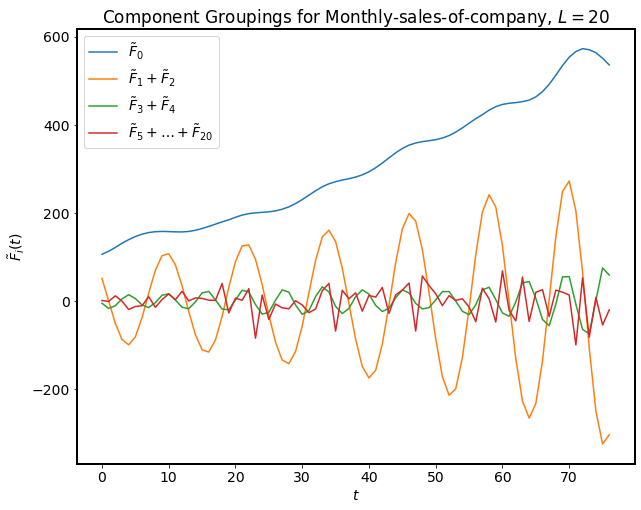

In [30]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2]).plot()
F_ssa_L20.reconstruct([3,4]).plot()
F_ssa_L20.reconstruct(slice(5,20)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Monthly-sales-of-company, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$", 
            r"$\tilde{F}_3+\tilde{F}_4$", 
            r"$\tilde{F}_5+ \ldots + \tilde{F}_{20}$"
           ]);

При $L = 20$ мы начинаем видеть тренд и периодические компоненты начинают обретать форму. Одиночная составляющая $\tilde{F}_0$ выглядит как возрастающий тренд, а группа $\tilde{F}_1 + \tilde{F}_2$ - расширяющаяся периодическая составляющая. Компоненты $\tilde{F}_3 + \tilde{F}_4$ похожи на синусоиду, а $\tilde{F}_5+ \ldots + \tilde{F}_{20}$ - шум.

##  $L = 37$<a name="Section5.4"></a>

Еще раз, мы увеличим до максимума длину окна и сначала проверим w-корреляционную матрицу.

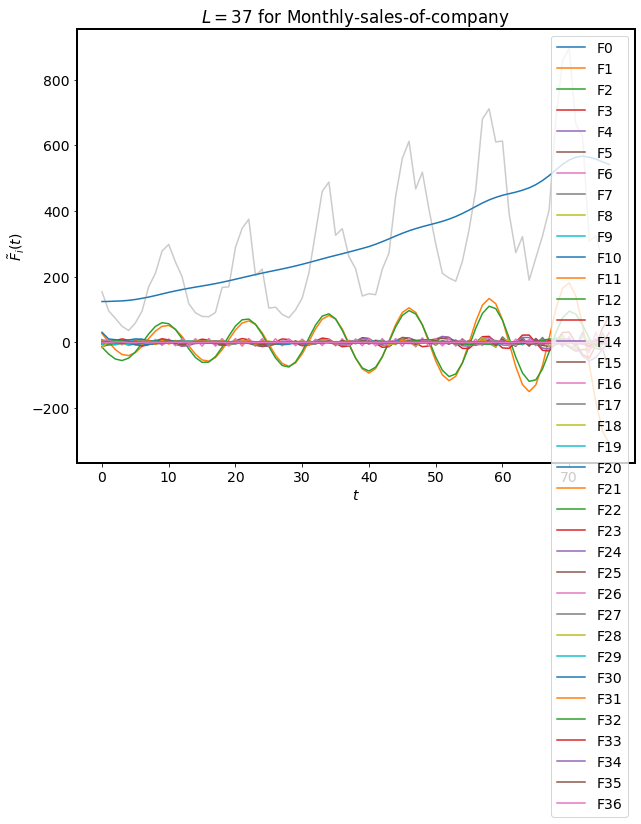

In [37]:
F_ssa_L37 = SSA(df, 37)
F_ssa_L37.components_to_df().plot()
F_ssa_L37.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=37$ for Monthly-sales-of-company");
plt.show()

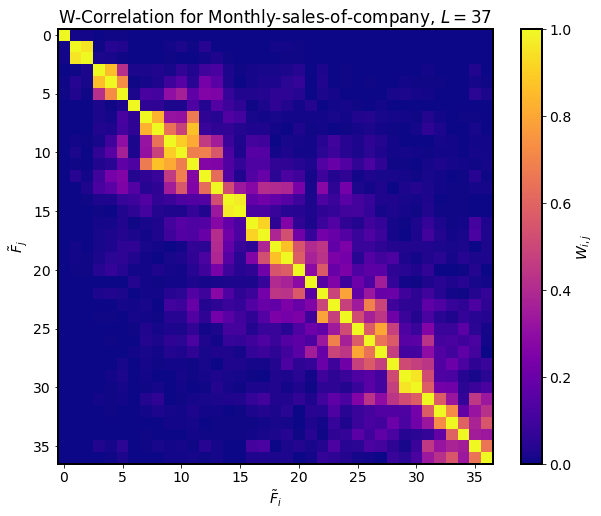

In [38]:
F_ssa_L37.plot_wcorr()
plt.title("W-Correlation for Monthly-sales-of-company, $L=37$");

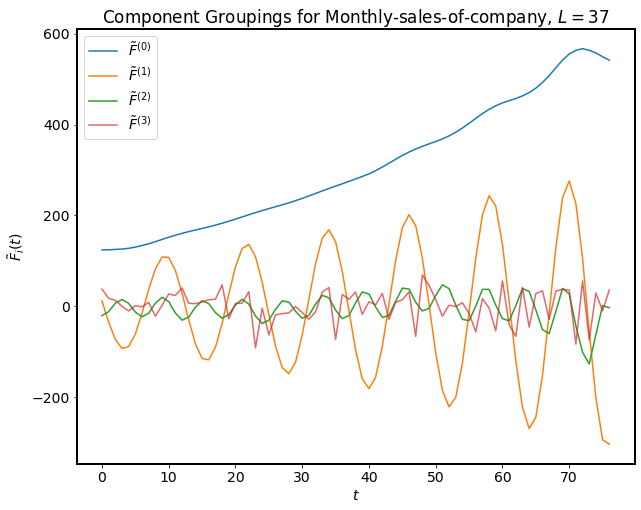

In [40]:
F_ssa_L37.reconstruct(0).plot()
F_ssa_L37.reconstruct([1,2]).plot()
F_ssa_L37.reconstruct([3,4,5]).plot()
F_ssa_L37.reconstruct(slice(6,37)).plot(alpha=0.7)
plt.title("Component Groupings for Monthly-sales-of-company, $L=37$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)]);

Из приведенного выше графика видно, что трендовая составляющая $\tilde{F}_0$ является трендом, который доходит до определённого уровня и начинает нисрастущий тренд, возможно, если бы данных было больше, то можно было бы выделить ещё какую-то составляющую, а так только N/2 , где N -количество данных( у нас это 77). Про разложение сказать тоже про составляющую $\tilde{F}_1$, внутри которой две очень сильно скореллированные синусоиды. На самом деле разница между длиной окна 20 и 37 не столь велика, однако между 5 и 20 видны значительные различия, например, видим, что выделились две синусоиды из основного временного ряда. Зато можно выделить периодичность и основной тренд из данного ВР.

В SSA нет жестких и быстрых правил для установки идеальной длины окна, выходящей за пределы $2 \le L \le N/2$. Тем не менее, иногда требуется более длинная длина окна (до 30-45% длины временного ряда), чтобы адекватно отделить лежащие в основе периодичности от общего тренда. Некоторые методы проб и ошибок необходимы, но часто легко начать с "достаточно большой" длины окна и работать оттуда.